## Visualizing embeddings

### Load trained model

In [31]:
import torch
import numpy as np
from models.net5g_two_head import ClusterNet5gTwoHead
import argparse


class Config:
    batchnorm_track = False
    num_sub_heads = 5
    output_k_A = 50
    output_k_B = 10
    input_sz = 32
    rand_crop_sz = 20
    include_rgb = False
    batch_sz = 700
    num_classes = 10
    
config = Config()

config.output_k = config.output_k_B

if config.include_rgb:
    config.in_channels = 5
else:
    config.in_channels = 2

model = ClusterNet5gTwoHead(config)
model = torch.nn.DataParallel(model)
model.load_state_dict(torch.load("results/iic-adapt.pt"))
model = model.cuda()


avg_pool_sz 3
semisup: False


### Get all embeddings from the model

In [27]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from utils.transforms import custom_greyscale_to_tensor
from utils.data import get_latent_and_targets

# Load src dataset
src_tf = transforms.Compose([
    transforms.CenterCrop(config.rand_crop_sz),
    transforms.Resize(config.input_sz),
    custom_greyscale_to_tensor(config.include_rgb),
])
src_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=src_tf)



# Load dest dataset
dest_tf = transforms.Compose([
    transforms.CenterCrop(config.rand_crop_sz),
    transforms.Resize(config.input_sz),
    custom_greyscale_to_tensor(config.include_rgb),
])
dest_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=dest_tf)

src_loader = DataLoader(src_dataset, batch_size=config.batch_sz, shuffle=False)
dest_loader = DataLoader(dest_dataset, batch_size=config.batch_sz, shuffle=False)



Using downloaded and verified file: ./data/test_32x32.mat


### Get best subhead by getting best accuracy

In [35]:
from utils.data import get_preds_and_targets, get_preds_actual_class
from utils.eval_metrics import hungarian_match, accuracy

src_preds, src_targets = get_preds_and_targets(config, model, src_loader, src_dataset)
dest_preds, dest_targets = get_preds_and_targets(config, model, dest_loader, dest_dataset)

src_preds = src_preds.cuda()
src_targets = src_targets.cuda()

dest_preds = dest_preds.cuda()
dest_targets = dest_targets.cuda()


def get_stats(preds, targets):
    matches = []
    accs = []
    for i in range(config.num_sub_heads):
        match = hungarian_match(preds[i], targets, num_classes=config.num_classes)
        matches.append(match)
        actual_preds = get_preds_actual_class(preds[i], match, config)
        acc = accuracy(actual_preds, targets, config.num_classes)
        accs.append(acc)

    best_subhead = np.argmax(accs)
    worst_subhead = np.argmin(accs)
    
    return {
        "best_subhead": best_subhead,
        "worst_subhead": worst_subhead,
        "accs": accs,
        "avg": np.mean(accs),
        "std": np.std(accs),
        "best": accs[best_subhead],
        "worst": accs[worst_subhead],
        "best_train_sub_head": matches[best_subhead]
    }

def print_stats(stats):
    for key in stats:
        print("{} : {}".format(key, stats[key]))
    print()

src_stats = get_stats(src_preds, src_targets)
dest_stats = get_stats(dest_preds, dest_targets)

print("Src Stats")
print_stats(src_stats)

print("Dest Stats")
print_stats(dest_stats)


Src Stats
Stats:
best_subhead : 1
worst_subhead : 2
accs : [0.3129166666666667, 0.3182, 0.31285, 0.3157, 0.31575]
avg : 0.31508333333333327
std : 0.002010997541299107
best : 0.3182
worst : 0.31285
best_train_sub_head : [(0, 7), (1, 9), (2, 8), (3, 1), (4, 3), (5, 6), (6, 2), (7, 0), (8, 4), (9, 5)]

Dest Stats
Stats:
best_subhead : 1
worst_subhead : 0
accs : [0.2676705593116165, 0.2816533497234173, 0.26828518746158575, 0.26913030116779346, 0.2807698217578365]
avg : 0.2735018438844499
std : 0.006318201002467138
best : 0.2816533497234173
worst : 0.2676705593116165
best_train_sub_head : [(0, 3), (1, 2), (2, 0), (3, 5), (4, 1), (5, 8), (6, 4), (7, 9), (8, 7), (9, 6)]



In [36]:
src_latents, src_targets = get_latent_and_targets(config, model, src_loader, src_dataset)
dest_latents, dest_targets = get_latent_and_targets(config, model, dest_loader, dest_dataset)

src_latents = src_latents[src_stats["best_subhead"]].cpu().numpy()
src_targets = src_targets.cpu().numpy()

dest_latents = dest_latents[dest_stats["best_subhead"]].cpu().numpy()
dest_targets = dest_targets.cpu().numpy()

print("Src Latents Size: {}".format(src_latents.shape))
print("Src Targets Size: {}".format(src_targets.shape))

print("Dest Latents Size: {}".format(dest_latents.shape))
print("Dest Targets Size: {}".format(dest_targets.shape))

Src Latents Size: (60000, 10)
Src Targets Size: (60000,)
Dest Latents Size: (26032, 10)
Dest Targets Size: (26032,)


### Reduce latent vectors dimension with tSNE

In [37]:
from sklearn.manifold import TSNE

src_latents_reduced = TSNE(n_components=2, verbose=True, n_jobs=4).fit_transform(src_latents)
dest_latents_reduced = TSNE(n_components=2, verbose=True, n_jobs=4).fit_transform(dest_latents)

print("Src Latents Reduced Size: {}".format(src_latents_reduced.shape))
print("Dest Latents Reduced Size: {}".format(dest_latents_reduced.shape))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 60000 samples in 0.144s...
[t-SNE] Computed neighbors for 60000 samples in 1.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 60000
[t-SNE] Computed conditional probabilities for sample 2000 / 60000
[t-SNE] Computed conditional probabilities for sample 3000 / 60000
[t-SNE] Computed conditional probabilities for sample 4000 / 60000
[t-SNE] Computed conditional probabilities for sample 5000 / 60000
[t-SNE] Computed conditional probabilities for sample 6000 / 60000
[t-SNE] Computed conditional probabilities for sample 7000 / 60000
[t-SNE] Computed conditional probabilities for sample 8000 / 60000
[t-SNE] Computed conditional probabilities for sample 9000 / 60000
[t-SNE] Computed conditional probabilities for sample 10000 / 60000
[t-SNE] Computed conditional probabilities for sample 11000 / 60000
[t-SNE] Computed conditional probabilities for sample 12000 / 60000
[t-SNE] Computed conditional probabilities for sam

### Visualize embeddings of source dataset

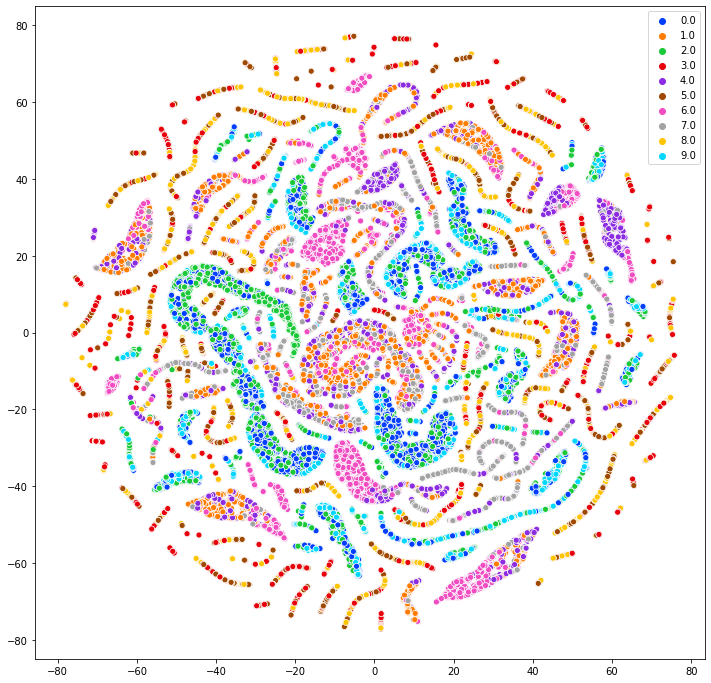

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(12, 12))
sns.scatterplot(src_latents_reduced[:, 0], src_latents_reduced[:, 1], hue=src_targets, legend='full', palette=palette)

### Visualize embeddings of dest dataset

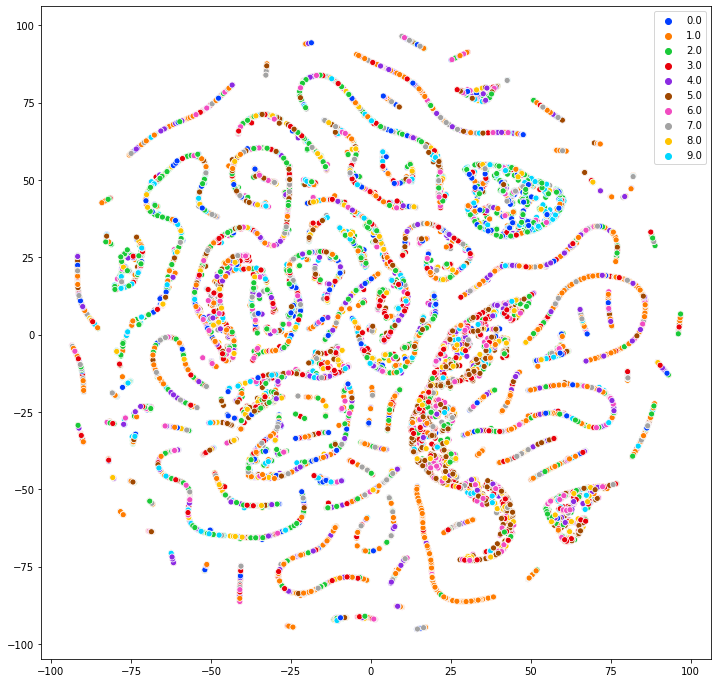

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
palette = sns.color_palette("bright", 10)
plt.figure(figsize=(12, 12))
sns.scatterplot(dest_latents_reduced[:, 0], dest_latents_reduced[:, 1], hue=dest_targets, legend='full', palette=palette)